In [1]:
!python3 --version
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, Aer, execute
from scipy.optimize import minimize

Python 3.6.8


The Fauseweh-Zhu paper [here](https://arxiv.org/pdf/2112.04276).

Optimization library in
- [Julia](https://julianlsolvers.github.io/Optim.jl/stable/algo/linesearch/)
- [Python](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) (BFGS)

In [2]:
chain_length = 4

num_layers = 1

shots = 2000

In [3]:
parameter_space_size = 2 * chain_length + 3 * chain_length * num_layers

param_space = [0]*parameter_space_size

In [4]:
def ansatz_circuit_0(qc, param_space):
    # layer 0
    param_counter = 0
    for i in range(chain_length):
        qc.rx(param_space[param_counter],i)
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1
    
def ansatz_circuit_1(qc, param_space):
    param_counter = 2 * chain_length
    for i in range(chain_length-1):
        qc.cx(i,i+1)
    qc.cx(-1,0)
    for i in range(chain_length):
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1
        qc.rx(param_space[param_counter],i)
        param_counter=param_counter+1
        qc.rz(param_space[param_counter],i)

def create_ansatz_circuit(qc, num_layers=num_layers, param_space=param_space):
    ansatz_circuit_0(qc, param_space)
    for i in range(num_layers):
        ansatz_circuit_1(qc, param_space)

def ansatz_circuit_ladder(qc, param_space):
    register_size = chain_length*2
    # layer 0
    param_counter = 0
    for i in range(register_size):
        qc.rx(param_space[param_counter],i)
        param_counter=param_counter+1
    for i in range(register_size):
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1
    for i in range(1,register_size//2):
        place = 2 * i - 1
        qc.cx(place,place+1)
    # qc.cx(-1,0)

def simulate(shots=shots):
    ## Run this cell to simulate 'qpe4' and to plot the histogram of the result
    sim = Aer.get_backend('aer_simulator')
    count_qpe4 = execute(qpe4, sim, shots=shots).result().get_counts()
    plot_histogram(count_qpe4, figsize=(9,5))


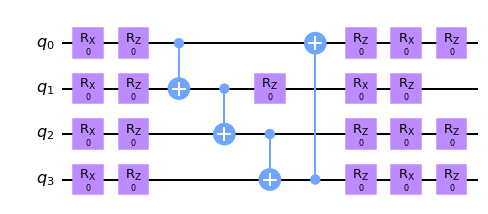

In [5]:
qc = QuantumCircuit(chain_length)

create_ansatz_circuit(qc)

# qc.measure_all()

qc.draw('mpl')

In [6]:
qc = ansatz_circuit_2(param_space)
qc.draw('mpl')

NameError: name 'ansatz_circuit_2' is not defined